In [1]:
import torch.optim as optim
from datetime import datetime

In [2]:
from transformer import Transformer
from preprocessing import *
from utils import *
from features import *

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.)
else:
    device = torch.device("cpu")

In [4]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [5]:
seq_len = 48
scale_output = True
target_column = 'NO1_consumption'

In [6]:
features_to_add = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    (
        add_hour_columns,
        {}
    )
]

In [7]:
for feature in features_to_add:
    print(feature)

(<function pick_location_data at 0x16a824b80>, {'loc': [1]})
(<function add_season_columns at 0x16a8249d0>, {})
(<function shift_data at 0x16a824c10>, {'shift_min': 24, 'shift_max': 24, 'column_to_shift': 'NO1_consumption', 'new_column_name': 'consum'})
(<function add_hour_columns at 0x16a824a60>, {})


In [8]:
forecast_len=24

In [9]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (scalerInputMethod, scalerOutputMethod), df_target = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add,
        seq_len=seq_len,
        forecast_len=24,
        scale_output=scale_output
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'consum_24_previous', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [10]:
X_train.shape, y_train.shape

(torch.Size([40861, 48, 30]), torch.Size([40861, 48, 1]))

In [11]:
X_train.shape

torch.Size([40861, 48, 30])

In [12]:
model = Transformer(input_size=X_train.shape[2])

In [13]:
model.to(device)

Transformer(
  (embedding): Linear(in_features=30, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# path = "Transformer-2024-03-20-loss-0.035382744"
# path = "models/" + path
# model.load_state_dict(torch.load(path))
# model.to(device)

In [15]:
lr = 1e-3
num_epochs=100

In [16]:
loss_func = nn.MSELoss()# .to(device)
opt = optim.Adam(model.parameters(), lr=lr)

In [17]:
model, losses, val_loss, opt = fit(
    model, 
    train_set=(X_train, y_train),
    val_set=(X_val, y_val),
    opt=opt,
    loss_func=loss_func,
    num_epochs=num_epochs,
    device=device,
    batch_size=30
)

device: mps


 52%|█████▏    | 52/100 [57:17<1:11:45, 89.70s/it]

In [ ]:
path = f'models/Transformer-{str(datetime.now().date())}-loss-{str(losses[len(losses)-1])}'
torch.save(model.state_dict(), path)

In [ ]:
plt.plot(losses, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

In [ ]:
y_test, y_pred = predict(model, scalerOutputMethod, (X_test, y_test))

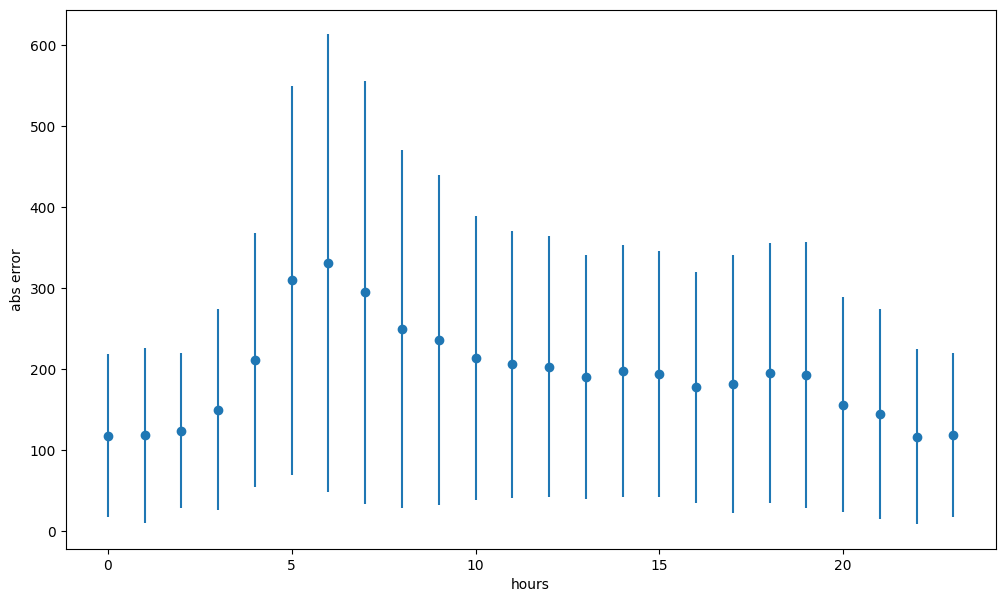

In [ ]:
plot_error_by_hour_for_test_set(y_test, y_pred, start_hour=df_target['timestamp'].dt.hour.iloc[seq_len-1])

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


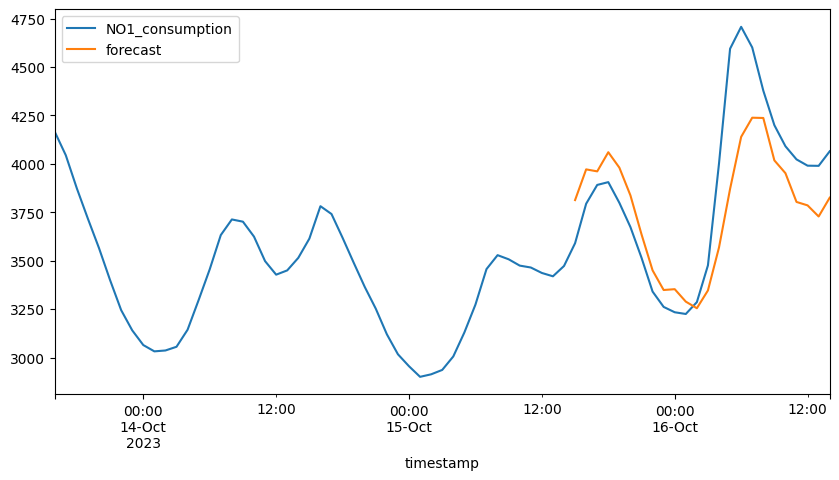

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


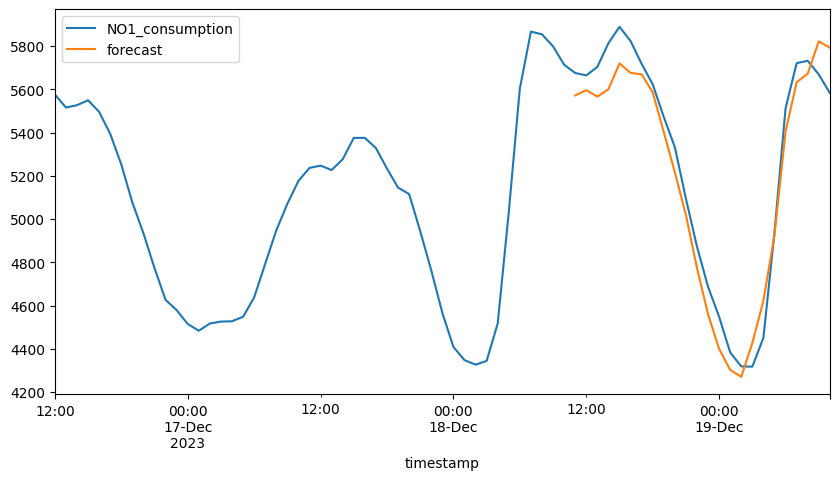

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


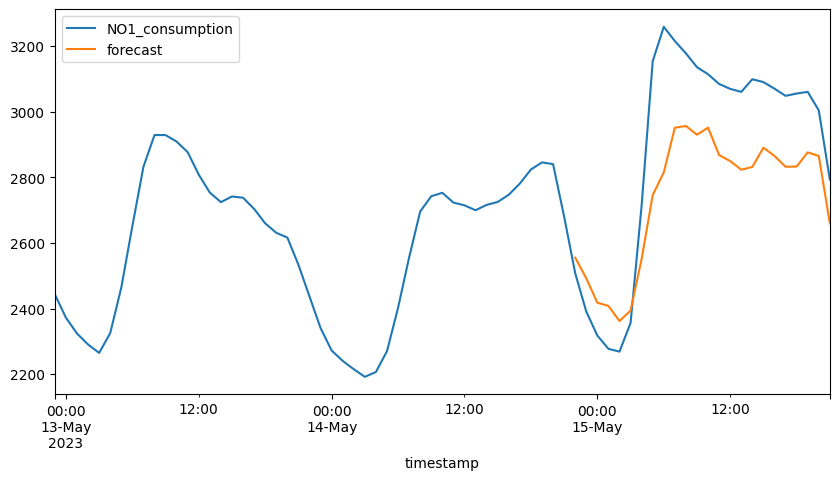

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


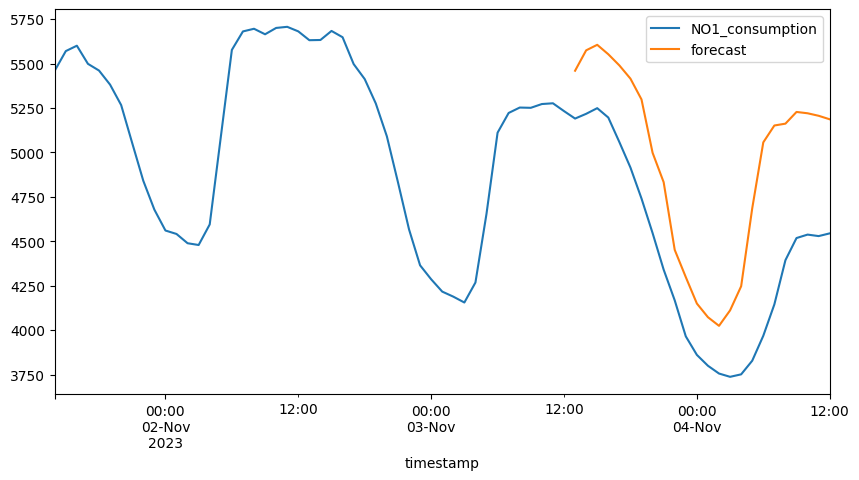

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


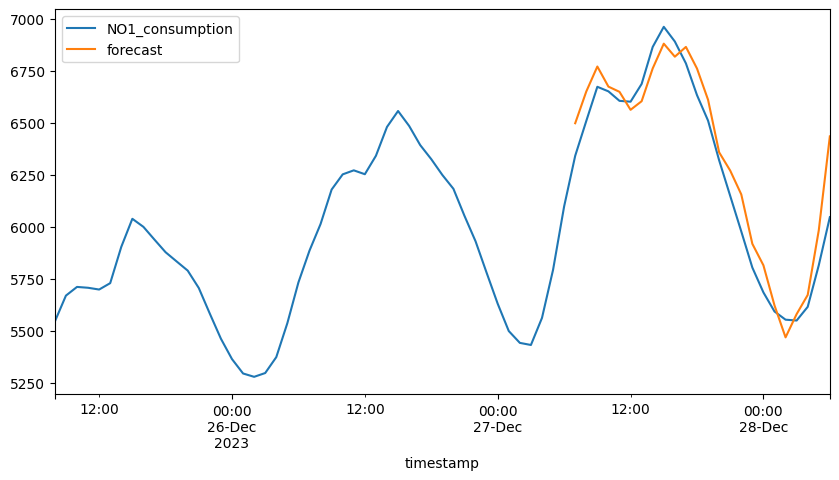

In [ ]:
for k in range(5):
    make_forecast(y_pred=y_pred, df_target=df_target, seq_len=seq_len)